# Statistiques Devoir 1

Sophie Corbel

In [80]:
#import des libraries nécessaires aux 3 exercices
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn import linear_model
from scipy.stats import t
import math
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
from sklearn.utils import resample
from IPython.display import clear_output
from sklearn.linear_model.base import LinearModel, _pre_fit
from sklearn.base import RegressorMixin

%matplotlib inline

###Exercice 1

#### 1) Écrire mathématiquement le modèle linéaire correspondant

Il s'agit du modèle :

$y_i = {\theta}_0^{*} + \sum_{j=1}^{p} {\theta}_j^{*}x_{ij} + {\epsilon}_i$    
avec : ${\epsilon}_i = {\cal{N}}(0,{\sigma}^2)~~~~~~~~~~ \forall i = 1,...,n$

$y_i$ est une observation ici la concentration en ozone

$x_{ij}$ est une variable explicative ici l'ensemble des variables du fichier airquality exceptée ozone

${\epsilon}_i$ est un bruit supposé i.i.d, gaussien

Un estimateur naturel des ${\theta}_j^{*}$ s'évalue par la méthode des moindres carrés

#### 2)+3) Récupération du jeu de données et élimination des lignes comportant des valeurs manquantes (NaN)

In [2]:
data = sm.datasets.get_rdataset('airquality').data
data = data.dropna(axis=0)
data.head()

,Ozone,Solar.R,Wind,Temp,Month,Day
0,41,190,7.4,67,5,1
1,36,118,8.0,72,5,2
2,12,149,12.6,74,5,3
3,18,313,11.5,62,5,4
6,23,299,8.6,65,5,7


#### 4) Application de la méthode des moindres carrés en régressant la varaible "Ozone" sur les 5 autres( utilisation de sklearn)

In [3]:
X=data[['Solar.R','Wind','Temp','Month','Day']]
Y=data['Ozone']
skl_linmod = linear_model.LinearRegression()
# Les variables explicatives sont centrées et réduites au préalable
scaler = preprocessing.StandardScaler().fit(X)
X=scaler.transform(X)
skl_linmod.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### 5.1) Estimateur des moindres carrés des coefficients du modèle avec l'ordonnée à l'origine

In [40]:
display(Math(r'{\theta}_0^{*}='+r'{0}'.format(skl_linmod.intercept_)))
display(Math(r'{\theta}_1^{*}[Solar.R]='+r'{0}'.format(skl_linmod.coef_[0])))
display(Math(r'{\theta}_1^{*}[Wind]='+r'{0}'.format(skl_linmod.coef_[1])))
display(Math(r'{\theta}_1^{*}[Temp]='+r'{0}'.format(skl_linmod.coef_[2])))
display(Math(r'{\theta}_1^{*}[Month]='+r'{0}'.format(skl_linmod.coef_[3])))
display(Math(r'{\theta}_1^{*}[Day]='+r'{0}'.format(skl_linmod.coef_[4])))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

#### 5.2) Expression théorique d'un estimateur sans biais de la variance du bruit et résultat

 ${\widehat\sigma}^2 = \frac{1}{n-rg(X)}{\left \| y - X{\widehat\theta} \right \|}^2_2$

In [41]:
residus = Y - skl_linmod.predict(X)
#Le rang de la matrice utilisée par sklearn vaut rang(X)+1 , fit_intercept étant à True
sigma2 = residus.dot(residus.T)/(Y.size-np.linalg.matrix_rank(X)-1)
sigma2

435.07549499192351

#### 6)Loi de Student: calcul de  intervalle de confiance à 99% pour chacun des ${\theta}_j^{*}$ de la formule

In [67]:
nbDegresLiberte = Y.size-np.linalg.matrix_rank(X)-1
interval = t.interval(0.99,nbDegresLiberte)
XPlusOnes = np.c_[ np.ones( Y.size), X ]
gramMatrix = XPlusOnes.T.dot(XPlusOnes)
invGramMatrix = np.linalg.inv(gramMatrix)
theta = theta1[:]
theta = np.insert(theta,0,theta0)
gap = interval[1]*math.sqrt(sigma2)*np.sqrt(invGramMatrix.diagonal())
icStudentLow = theta - gap
icStudentHigh = theta + gap
display(Math(r'IC_0=['+r'{0}'.format(icStudentLow[0])+r','+r'{0}'.format(icStudentHigh[0])+r']'))
display(Math(r'IC[Solar.R]=['+r'{0}'.format(icStudentLow[1])+r','+r'{0}'.format(icStudentHigh[1])+r']'))
display(Math(r'IC[WInd]=['+r'{0}'.format(icStudentLow[2])+r','+r'{0}'.format(icStudentHigh[2])+r']'))
display(Math(r'IC[Temp]=['+r'{0}'.format(icStudentLow[3])+r','+r'{0}'.format(icStudentHigh[3])+r']'))
display(Math(r'IC[Month]=['+r'{0}'.format(icStudentLow[4])+r','+r'{0}'.format(icStudentHigh[4])+r']'))
display(Math(r'IC[Day]=['+r'{0}'.format(icStudentLow[5])+r','+r'{0}'.format(icStudentHigh[5])+r']'))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

#### 7) Pertinence des variables "Day" et "Month" (condidérées séparément)

Les intervalles de confiance des variables "Day" et "Month" contiennent la valeur 0, il est possible que ces variables ne soient pas significatives.

#### 8) Prévision du modèle avec l'observation Solar.R=17, Wind=10, Temp=70,Day=1,Month=3

In [86]:
X1 = [[197.0,10.0,70.0,3.0,1.0]]
#Scaler défini en 4)
X1= scaler.transform(X1)
Y1 = theta0 + X1.dot(theta1)
Y1[0]

36.462337868083267

###Exercice 2 Intervalle de confiance et bootstrap

#### 1) Estimateurs des coefficients obtenus par une moyenne, puis par une médiane

In [74]:
# Fonction appliquant itérativement une régression linéaire sur une suite d'échantilons
# obtenus par la fontion resample de sklearn
# data : jeu de données
# n_bootstraps : nombre d'itérations
# n_exemples : taille de l'échantillon
# skl_linmod : modèle sklearn
# scaler : formatteur
# la fonction retourne une liste des vecteurs de coefficients résultats de la régression
def bootstrap_linear(data, n_bootstraps,n_exemples,skl_linmod,scaler):
    bootstraps = []
    for _ in range(n_bootstraps):
        # Sample with replacement from data
        samples = resample(data,n_samples = n_exemples)
        newTheta = linear_reg(samples,skl_linmod,scaler)
        bootstraps.append(newTheta)
    return pd.DataFrame(bootstraps)

# Fonction appliquant la régression linéaire de sklearn sur des données de airquality 
# l'observation étant la concentration en ozone
# les variables explicatives les 5 autres variables du fichier
# data : jeu de données
# skl_linmod : modèle sklearn
# scaler : formatteur
# La fonction retourne un tableau des coefficients incluant l'ordonnée à l'origine
def linear_reg(data,skl_linmod,scaler):
    X=data[['Solar.R','Wind','Temp','Month','Day']]
    Y=data['Ozone']
    scaler = preprocessing.StandardScaler().fit(X)
    X=scaler.transform(X)
    skl_linmod.fit(X, Y)
    theta = skl_linmod.coef_[:]
    theta = np.insert(theta,0,skl_linmod.intercept_)
    return theta

bootstraps = bootstrap_linear(data, 10000, None,skl_linmod,scaler)
bootstraps.columns=['Intercept','Solar.R','Wind','Temp','Month','Day']


In [75]:
bootstraps.mean()

Intercept    42.127911
Solar.R       4.570308
Wind        -11.769231
Temp         17.880432
Month        -4.401369
Day           2.423097
dtype: float64

In [76]:
bootstraps.median()

Intercept    42.054054
Solar.R       4.530135
Wind        -11.641544
Temp         17.867149
Month        -4.383086
Day           2.447134
dtype: float64

#### 2) Intervalle de confiance de niveau 99%, en utilisant les quantiles empiriques de niveaux 99.5% et 0.5% des échantillons bootstraps

In [77]:
low_ic_value = 0.005
high_ic_value = 0.995
bootstraps.quantile([low_ic_value,high_ic_value])

,Intercept,Solar.R,Wind,Temp,Month,Day
0.005,34.414369,-0.075456,-20.415947,11.725272,-9.650420,-3.001871
0.995,50.666757,9.566730,-4.921800,23.952327,0.861148,7.785468


#### 3) On fait varier le nombre d'échantillons B de 1 à 5001 par saut de 500 et on calcule les intervalles de  confiances à chaque pas. Pour la variable Wind, on affiche sur un graphe les courbes donnant les bornes inférieures et les bornes supérieures (en pointillés noirs) ainsi que la courbe des estimés par la médiane (en rouge)

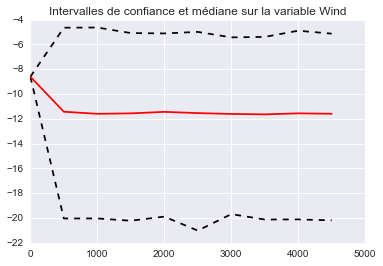

In [78]:
# Fonction appliquant itérativement une régression linéaire sur une suite d'échantillons
# obtenus par la fontion resample de sklearn et qui sur les coefficients obtenus
# détermine un intervalle de confiance
# data : jeu de données
# n_bootstraps : nombre d'itérations
# n_exemples : taille de l'échantillon
# low_ic_value : borne inférieure de l'intervalle de confiance
# high_ic_value : borne supérieure de l'intervalle de confiance
# skl_linmod : modèle sklearn
# scaler : formatteur
# la fonction retourne d'une part une liste d'intervalles de confiances, d'autre part une liste de moyenne
# chaque liste étant indexée par le pas de l'itération
def bootstrap_CI(data, n_bootstraps,n_exemples,low_ic_value,high_ic_value,skl_linmod,scaler):
    bootstraps = bootstrap_linear(data,n_bootstraps,n_exemples,skl_linmod,scaler)
    CIdf = bootstraps.quantile([low_ic_value,high_ic_value])
    medianSerie = bootstraps.median()
    return CIdf,medianSerie

WindMedian=[]
WindLowIc=[]
WindHighIc=[]

#Wind variable correspondant à la seconde colonne
for B in range(1,5001,500):
    CIdf,MedianSerie = bootstrap_CI(data,B,None,low_ic_value,high_ic_value,skl_linmod,scaler)
    WindMedian.append(MedianSerie[2])
    WindLowIc.append(CIdf[2][low_ic_value])
    WindHighIc.append(CIdf[2][high_ic_value])

XWInd = np.arange(1,5001,500)
plt.title('Intervalles de confiance et médiane sur la variable Wind')
plt.plot(XWInd,WindLowIc,"k--")
plt.plot(XWInd,WindHighIc,"k--")
plt.plot(XWInd,WindMedian,color="red")
plt.show()



#### 4) Utiliser lmplot de seaborm pour afficher sur un même graphique les points et les droites de régression correspondant à faire une régression de la variable "Ozone" sur "Wind" mois par mois, donner le mois qui semble atypique

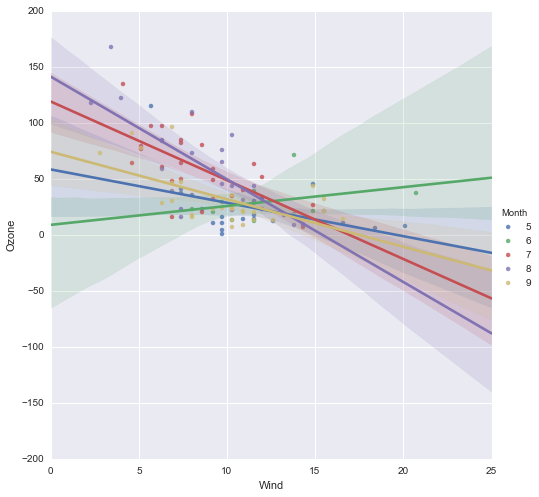

In [79]:
sns.lmplot('Wind','Ozone',hue='Month',data=data,size=7)
sns.plt.show()

Le mois de juin semble atypique

### Exercice 3

#### 1)-2) Ecriture de la fonction stpforward (selon le pseudo-code de l'algorithme 1) prenant en arguments : les observations Y, la matrice X et un paramètre M nombre maximum de variables sélectionnées. En sortie, elle renvoie le vecteur  ${\theta}$ et la liste des S des indices sélectionnés. Le vecteur ${\theta}$ a les coordonnées nulles sauf les ${\theta}_j$ pour j appartenant à S.  Cette fonction est membre de la classe MYOMP dont le code est donné ci-dessous

In [83]:
class MYOMP(LinearModel, RegressorMixin):
    def __init__(self, n_nonzero_coefs=None, fit_intercept=True,normalize=True, precompute='auto'):
        self.n_nonzero_coefs = n_nonzero_coefs
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.precompute = precompute

    def fit(self, X, y):
        """Fit the model using X, y as training data.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
        Training data.
        y : array-like, shape (n_samples,) or (n_samples, n_targets)
        Target values.
        Returns
        -------
        self : object
        returns an instance of self.
        """
        X, y, X_mean, y_mean, X_std, Gram, Xy = \
        _pre_fit(X, y, None, self.precompute, self.normalize,
        self.fit_intercept, copy=True)
        self.coef_,self.featuresIndex_=self.stpforward(X,y)
        self._set_intercept(X_mean, y_mean, X_std)
        return self

    def stpforward(self,X,y,M=None):
        r=y
        S=[]
        if M==None:
            M=self.n_nonzero_coefs
        if self.normalize:
            preprocessing.scale(X)
        # Normalization in LinearRegression is not the same as the preprocessing.scale (?)
        skl_linmod = linear_model.LinearRegression(True, self.fit_intercept, False)
        if  M==None :
            # Régression standard
            skl_linmod.fit(X, Y)
            newCoef = skl_linmod.coef_[:]
        else :
            Xs=np.zeros((y.size,M))
            for m in range(0,M):
                # Sélection du meilleur produit scalaire sur les variables non déjà sélectionnées
                diffList = list(set(range(0,M)) - set(S))
                scalarProducDic={}
                for i in diffList:
                    scalarProducDic[i]=r.dot(X[:,i])
                maxScalarProduct = max(list(scalarProducDic.values()))
                for k,v in scalarProducDic.items():
                    if v == maxScalarProduct:
                        maxScalarProductIndex=k
                        break
                S.append(maxScalarProductIndex)
                # Calcul du résidu de la régression pour la variable sélectionnée
                Xs[:,m]=X[:,maxScalarProductIndex]
                X1 = np.zeros((y.size,1))
                X1[:,0]=X[:,maxScalarProductIndex]
                skl_linmod.fit(X1, Y)
                r = Y-skl_linmod.predict(X1)

            # Régression avec la matrice des M variables sélectionnées
            skl_linmod.fit(Xs, Y)
            coef = skl_linmod.coef_[:]
            if self.fit_intercept:
                self.intercept_ = skl_linmod.intercept_

            # Constitution du vecteur final la valeur pour les variables non sélectionnées étant à 0
            newCoef=np.zeros(X.shape[1])
            for i in range(X.shape[1]):
                if i in S:
                    newCoef[i] = coef[S.index(i)]

        return newCoef,S



#### 3) Appliquer MYOMP au jeu de données airquality pour M=3,4,5

In [84]:
X=data[['Solar.R','Wind','Temp','Month','Day']]
Y=data['Ozone']
for i in [3,4,5]:
    myOmp = MYOMP(i)
    myOmp = myOmp.fit(X,Y)
    print("M=",i," myOmp.coef_=",myOmp.coef_)

M= 3  myOmp.coef_= [ 0.05982059 -3.33359131  1.65209291  0.          0.        ]
M= 4  myOmp.coef_= [ 0.04959683 -3.3165094   1.87087379 -2.99162786  0.        ]
M= 5  myOmp.coef_= [ 0.05027432 -3.31844386  1.89578642 -3.03995664  0.27387752]


#### 4) Comparer votre sortie avec celle de OrthogonalMatchingPursuit de sklearn .

In [85]:

for i in [3,4,5]:
    omp = linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs=i)
    omp.fit(X, Y)
    print("M=",i," omp.coef=",omp.coef_)


M= 3  omp.coef= [ 0.05982059 -3.33359131  1.65209291  0.          0.        ]
M= 4  omp.coef= [ 0.04959683 -3.3165094   1.87087379 -2.99162786  0.        ]
M= 5  omp.coef= [ 0.05027432 -3.31844386  1.89578642 -3.03995664  0.27387752]


Les résultats sont identiques